# Pneumonia Detection Using Chest X-Rays and Convolutional Neural Networks

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.linalg as lg
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.gridspec as gridspec

import os
import copy
import random

from torch.utils.data.sampler import SubsetRandomSampler


from tqdm import tqdm, tqdm_notebook
import scipy
import skimage
from skimage.transform import resize
#import cv2
#from torchsummary import summary
import seaborn as sns

#Note: This notebook was run on a machine with an Nvidia GTX 1660Ti (Max-Q), which has 6GB of vRAM. Running on less
#vRAM may require less epochs or smaller batch sizes 

## I. Introduction 
The current project aims to build a convolutional neural network to detect pneumonia from chest X-ray images. Pneumonia is defined as a lung inflammation disease that can be caused by bacteria, viruses or fungi [1].  Each type may have a different manifestation in X-ray images which makes the classification task more difficult. An example of the comparison between PNEUMONIA and NORMAL cases is presented below. As shown in the picture, due to liquid filling the lungs during the infection, there are usually hazy patches in the chest X-ray for PNEUMONIA cases. However, it is worth noting that such a conclusion is drawn solely from visual inspection of a subset of the images. It is likely that there are other distinguishing features that require much more domain knowledge to identify. Note that the code in this notebook makes use of a trained model and data that can be downloaded here: https://qmulprod-my.sharepoint.com/:u:/g/personal/ah19432_qmul_ac_uk/EVryOQTgoCdOi3tPAMspduABgz6XZj_1LTacKJrZQC_qww?e=IsZeWO. 


<figure>
    <img src="NORMAL VS PNEUMONIA.PNG" alt="drawing" width="500"/>
    <figcaption>Figure: Normal vs. Pneumonia [2].</figcaption>
</figure>



## II. Report Outline 
The remainder of this report is structured as follows. First, it provides a description of the current dataset, along with the data transformation techniques applied to the input. It then outlines the current neural network architecture and the rationale for the associated hyperparameter choices. Following this section, the optimisation method is then discussed in the context of the algorithm, learning rate choice, and the stopping criteria. Finally, we present the results obtained from our current model and discuss its potential implications.

## III. Dataset and Pre-processing 
The current dataset, obtained from Kaggle, contains a total of 5830 images, which are pre-sorted into training, validation, and testing sets with sizes of 5190, 16, and 624 respectively [2]. Since a validation set of size 16 may be too small to produce a generalisable result, we expanded its size to 100 by moving images from the training set. The input data are torch tensor representations of each image with normalised pixel intensities (ranging from 0 to 1) as features. Since the feature dimensions in the original dataset vary across images (e.g. 3x1469x993, 3x932x588), the images were resized to 3x224x224. All images are labelled as either NORMAL or PNEUMONIA. The proportions of the two classes are, however, imbalanced in all three sets with NORMAL to PNEUMONIA ratio being 25.61:74.38, 40:60, and 37.5:62.5 respectively. The code below reads in the input data and implements some of the data augmentation strategies to be discussed later.

In [ ]:
#If a CUDA enabled GPU is available, use it for the training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#File paths to the train, test and validation sets 
training_set_path = os.path.join(os.getcwd(), "data_224_224_big_val_flip", "train")
test_set_path = os.path.join(os.getcwd(), "data_224_224_big_val_flip", "test")
validation_set_path = os.path.join(os.getcwd(), "data_224_224_big_val_flip", "val")

#Setting the seed for random number generation
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
random.seed(0)

def get_loader(path, batch_size=16, shuffle=True, to_augment=True):
    """
    Function that returns a data loader given a data path with some included parameters for shuffling and augmentation.
    
    @param
    path: path to the data set to be loaded
    batch_size: size of each batch for the data loader
    shuffle: whether or not to shuffle data during iteration
    to_augment: whether or not to apply random transformations (rotation by 20 degrees / scaling by 1.2)
    
    @return
    torch DataLoader object that loads the data in the given path 
    """
    if to_augment:
        affine1=transforms.RandomAffine(degrees=20, translate=None, scale=None, shear=None, resample=False, fillcolor=0)
        affine2=transforms.RandomAffine(degrees=20, translate=None, scale=(1.2,1), shear=None, resample=False, fillcolor=0)
        random_affine=transforms.RandomApply([affine1,affine2],p=0.5)
        transform=transforms.Compose([
            random_affine,
            transforms.ToTensor()])
    else:
        transform = transforms.Compose([transforms.ToTensor()])
    data_folder = torchvision.datasets.ImageFolder(root=path,transform=transform)
    data_loader = torch.utils.data.DataLoader(data_folder,batch_size=batch_size, shuffle=shuffle)
    return data_loader

train_loader = get_loader(training_set_path)
test_loader = get_loader(test_set_path,batch_size=1,to_augment=False)
val_loader = get_loader(validation_set_path,to_augment=False)

Horizontal flipping was applied to the NORMAL images to help reduce the class imbalance in the training set. The validation and test set are kept unchanged for better generalisability, as in practice, one is likely to encounter class imbalances in unseen data. As a result, the total number of images in the training set increased to 6414, with a NORMAL to PNEUMONIA ratio of 40.79:59.21. Notice that the class imbalance was not completely eliminated as in medical diagnosis, false negatives are considered more costly than false positives. Therefore, a slight imbalance might help improve recall. Below is an example of an image before and after the horizontal flip. 

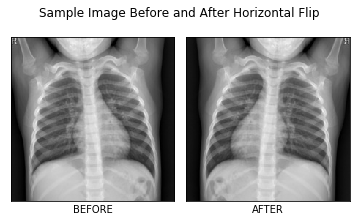

In [3]:
sample_img = cv2.imread("sample_input.jpeg")
flipped_image = cv2.flip(sample_img, 1)
fig, ax = plt.subplots() 
fig.suptitle("Sample Image Before and After Horizontal Flip", fontsize=12)
plt.subplot(1,2,1, xticks=[], yticks=[],xlabel="BEFORE")
plt.imshow(sample_img)
plt.subplot(1,2,2, xticks=[], yticks=[],xlabel="AFTER")
plt.imshow(flipped_image)
fig.tight_layout()
fig.subplots_adjust(top=1.3)
fig.set_size_inches(5,5)

On top of the horizontal flipping, two additional data augmentation strategies were applied, which are 20 degree rotations and a 120% rescale, both of which are applied with probability 50%. A 120% rescale was added on top of the rotation, as based on some experiments, this yieled better results than applying the two augmentation strategies separately. Similar to horizontal flipping, both strategies are only applied to the training set to increase the variability of our dataset in the hope of decreasing the chances of overfitting. An example of such data augmentation is demonstrated in the code below.

In [4]:
#Defining 1st transformation: 20 Degree rotation (randomly chosen to be clock-wise or anti-clockwise)
affine1=transforms.RandomAffine(degrees=20, translate=None, scale=None, shear=None, resample=False, fillcolor=0)
#Adding 120% rescaling on top of the rotation 
affine2=transforms.RandomAffine(degrees=20, translate=None, scale=(1.2,1), shear=None, resample=False, fillcolor=0)
#Loading a sample image 
sample_img = cv2.imread("sample_input.jpeg")
#Converting the image into PIL format
sample_img=transforms.ToPILImage()(sample_img)
#Applying the first transformation
rotated_img=affine1(sample_img)
#Applying the second transformation
scaled_img=affine2(sample_img)

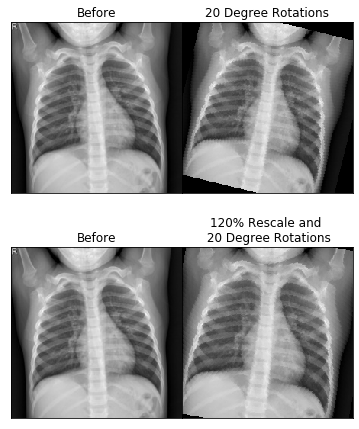

In [5]:
fig, ax = plt.subplots(2,2) 
plt.subplot(2,2,1, xticks=[], yticks=[])
plt.imshow(sample_img)
plt.title("Before")
plt.subplot(2,2,2, xticks=[], yticks=[])
plt.imshow(rotated_img)
plt.title("20 Degree Rotations")
plt.subplot(2,2,3, xticks=[], yticks=[])
plt.imshow(sample_img)
plt.title("Before")
plt.subplot(2,2,4, xticks=[], yticks=[])
plt.imshow(scaled_img)
plt.title("120% Rescale and \n 20 Degree Rotations")

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(top=1.3)
fig.set_size_inches(5,5)


## IV. Network Architecture 

The network presented here is a simplified version of the well-known VGG-16 [3]. Although the original VGG-16 network contains five convolutional layers, the current model only includes four, as based on experiments, additional convolutional layers did not improve model performance. For each convolutional layer, there are four parameter choices: number of filters, filter size, stride, and padding size. Following the same pattern as VGG-16, the model starts with 64 filters. This number is then doubled with each additional convolutional layer. Considering that, as mentioned previously, the main feature that distinguishes NORMAL and PNEUMONIA, i.e. the hazy patches due to liquid in the lungs, is relatively large in size, the filter size is uniformly set to be 5x5. Regarding the third parameter, the stride is, by convention, set to be one for all convolutional layers. 

In addition to the three parameter choices, the inputs into the convolutional layers could also be padded with a given layer of zeros. An example of which is shown in the picture below. 

<figure>
    <img src="PADDING.PNG" alt="drawing" width="500"/>
    <figcaption>Figure: Padding Illustration.</figcaption>
</figure>

Zero-padding serves the purpose of reducing the undersampling of pixels situated on the edges of the image [3]. The size of padding is chosen such that the spatial dimensions of each image remain the same as before the application of convolutions. The exact value is computed using the formula below, where $N$, $P$, $F$, and $S$ represent the spatial dimension of the image, padding size, filter size and stride respectively. 

$$\frac{N+2P-F}{S}+1=N$$

$$P=\frac{NS+F-S-N}{2}$$

$$P=\frac{5-1}{2}$$

$$P=2$$

After each convolutional layer, the inputs are first passed through a Relu activation function. Max-pooling was then applied to shrink the height and width of the image. By applying max-pooling, only the maximum of a given neighbourhood is retained. In addition to the reduction in computational cost, such operations also result in greater spatial invariance, as the output is  less affected by small variations to the small valued pixels. The kernel size of the first three pooling layers is set to be 2x2 with stride of two by convention. In order to ensure the size of data is compatible with the amount of available vRAM, a larger shrinkage is applied in the last pooling layer using a bigger kernel of size 4x4,with stride of 4. 

Similar to VGG-16, after the convolutional layers, the flattened image matrix is passed through three fully connected layers with Relu activations. Considering the limited vRAM capacity, the current model used fully-connected layers that are half the size of those in the original VGG-16 (2048 vs. 4096). Furthermore, since the fully connected layers are especially prone to overfitting, a dropout layer was added in front of every linear projection. The basic idea of dropout is visualised in the picture below. First, it zeroes out input neurons with a certain probability, which is set to be 0.1 in our case. The resulting values are then up-scaled by a factor of $\frac{1}{1-p}$ to keep the expectation approximately the same. 

<figure>
    <img src="DROPOUT.PNG" alt="drawing" width="500"/>
    <figcaption>Figure: Dropout Illustration [4].</figcaption>
</figure>

In addition to dropout, we also experimented with batch normalisation, which was intended to stabilise the layer inputs at the training stage. This is achieved by first normalising inputs with zero mean and unit variance. The normalised inputs are then scaled and shifted by two trainable parameters $\gamma$ and $\beta$, as shown in the formula below. 

$$z=\frac{a-E[a]}{\sqrt{Var[z]+\epsilon}}*\gamma+\beta$$

where $a$ and $z$ represent activation units and normalised output respectively. Despite its widespread use, adding a batch-normalisation layer before nonlinear activations in the convolutional layers achieved worse predictive performance on the current validation set. Although the performance improved slightly when we switched the order of activation layers and batch-normalisation layers, the result was still worse than without such modifications. The reason for this is not completely clear, as to date there is no consensus about the root of the effectiveness of batch-normalisation. Some attribute it to the reduced magnitude of the changes to the layer input distribution that result from parameter updates of previous layers (often referred as Internal Covariate Shift) [5]. However, others argue for its effect in smoothing out the landscape of the optimisation problem [6]. Since the reason for reduced effectiveness due to batch normalisation is unclear, we can only hypothesize about it.  Given that batch statistics computed at each batch-normalisation layer depend on the size of the mini-batch, a batch size of 16 might introduce large instabilities, which in turn could lead to inaccurately updated layer inputs. 


In [6]:
class Net(nn.Module):
    """
    Neural network class that the model is based on (see description of architecture above). 
    """
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3,64,5,stride=1,padding=2)tr
        self.conv2_1 = nn.Conv2d(64,128,5,stride=1,padding=2)
        self.conv3_1 = nn.Conv2d(128,256,5,stride=1,padding=2)
        self.conv4_1 = nn.Conv2d(256,512,5,stride=1,padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.big_pool = nn.MaxPool2d(4,4)
        self.fc1 = nn.Linear(7*7*512, 2048)
        self.fc2 = nn.Linear(2048,2048)
        self.fc3 = nn.Linear(2048,2)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        """
        Forward pass function for the neural network 
        """
        #1st Convolutional Layer
        #Input dimension: 3 x 224 x 224
        #Output dimension: 64 x 112 x 112 
        x = self.conv1_1(x)
        x = self.pool(F.relu(x))
        #2nd Convolutional Layer
        #Input dimension: 64 x 112 x 112 
        #Output dimension: 128 x 64 x 64
        x = self.conv2_1(x)
        x = self.pool(F.relu(x))
        #3rd Convolutional Layer
        #Input dimension: 128 x 56 x 56
        #Output dimension: 256 x 28 x 28 
        x = self.conv3_1(x)
        x = self.pool(F.relu(x))
        #4th Convolutional Layer
        #Input dimension: 256 x 28 x 28 
        #Output dimension: 512 x 7 x 7
        x = self.conv4_1(x)
        x = self.big_pool(F.relu(x))
        #Stretching out the image matrix into a vector 
        x = x.view(-1, 7*7*512)
        #Adding 10% dropout 
        x = self.dropout(x)
        #1st fully connected layer with Relu Activation
        #Input dimension: 25088
        #Output dimension: 2048
        x = F.relu(self.fc1(x))
        #Adding 10% dropout 
        x = self.dropout(x)
        #2nd fully connected layer with Relu Activation
        #Input dimension: 2048
        #Output dimension: 2048
        x = F.relu(self.fc2(x))
        #Adding 10% dropout 
        x = self.dropout(x)
        #3rd fully connected layer outputing classification outcomes
        #Input dimension: 2048
        #Output dimension: 2
        x = self.fc3(x)
        return x

In [7]:
#Torch summary of model. Commented out here because it may take some vRAM to run. 
#summary(model,(3,224,224))

## V. Optimisation 

This section presents the mathematical background and the programmatic implementation of the optimisation techniques used in the current project. Specifically, the discussion will revolve around our choice of optimiser, learning rate, momentum and stopping criteria. 

Regarding the optimiser, we adopted mini-batch stochastic gradient descent with a batch size of 16. This batch size is chosen based on our experimental results that suggest that as we increase batch size, the number of epochs we are able to run decreases due to vRAM limitations. Since in general, having the flexibility to run a greater number of epochs is considered more important in improving the model performance than being able to use a larger batch size, the batch size was not expanded any further.

The step size of our gradient descent algorithm is governed by the Cyclical Learning Rate Schedule, which works as follows [7]. First, based on a few experiments, we initialised a minimum and maximum learning rate of 0.015 and 0.05. Then as visualised in the picture below, the learning rate monotonically increases from the minimum value in the first $K=2000$ iterations. Once the maximum learning rate is reached, it will start to decrease in the following $M-K$ iterations, where $M$ represents the length of each cycle and was set to be $3000$. 


<figure>
    <img src="CYCLE LR v3.PNG" alt="drawing" width="600"/>
    <figcaption>Figure: Cyclical Learning Rate Mechanism [7].</figcaption>
</figure>

The exact mechanism underlying the update process is detailed in the following equations:

$$\quad c=\left\lfloor1+\frac{E}{M}\right\rfloor$$

$$x=\left|\frac{E}{K}-2 \times c+1\right|$$

$$lr=min\_lr+(max\_lr-min\_lr) \times max(0,1-x)$$

The rationale for using such a method is that by increasing learning rate at various time points, the optimiser is more likely to be able to traverse through the saddle point plateaus, which would otherwise be quite difficult to do if a small, fixed learning rate was used. 

The cyclical learning rate is also coupled with a cyclical momentum which is cycled inversely to the learning rate between minimum (0.8) and maximum (0.9) momentum. The update procedure is similar to the one shown above. The intuition behind momentum is visualised in the image below. 


<figure>
    <img src="MOMENTUM.PNG" alt="drawing" width="600"/>
    <figcaption>Figure: Momentum Illustration [8].</figcaption>
</figure>




Without the momentum, the gradient update usually follows a zig-zag pattern, which could be decomposed into $w1$ and $w2$ directions. However, oscillations in the $w1$ direction are generally considered undesirable as they would often slow down convergence. Such an issue can be overcome by computing exponentially weighted averages that keep track of the gradients from recent iterations. The modified update formula is shown below.

$$V_{dw}^{t}=\beta V_{dw}^{t−1}+(1−\beta)dw$$

$$W^{t+1}=W^{t}−\tau V_{dw}^{t}$$

The first line represents the iterative relationship between the current gradient ($ V_{dw}^{t−1}$) and the previous gradient ($dw$). The relative weight of the two is determined by the momentum parameter $\beta$. A higher momentum value often has a higher oscillation damping effect, but at the expense of lower sensitivity to the gradient from the current iteration. By computing such averages, the components in the $w1$ direction are cancelled out, while those in the $w2$ direction are reinforced, which leads to a more straightforward path to the minimum [8]. 

Having built an optimiser, we then turn to the problem of selecting an appropriate stopping point to avoid over and under fitting. The first option was to stop when the average validation loss stopped decreasing. Despite its widespread use in the deep learning community, it may be suboptimal given the size of the current validation set. We decided not to expand the validation set any further as it comes at the cost of reducing the size of the training set, which might deprive the model of potentially important information. However, a validation set of size 100 is likely to generate high stochastic errors which might lead to misguided stopping decisions. 

An alternative option is to select the stopping point based on the absolute difference between average training loss and average validation loss. A small difference indicates that the parameters learned at training performed almost equally as well on an unseen dataset.
When applied on the current dataset, based on results from 50 epochs, such criteria led to stopping at the 16th epoch with a loss difference of 0.000043. While having a validation loss lower than training loss is usually seen as a sign of overfitting, a slightly lower validation loss was allowed here since the deactivation of dropout layers during validation leads to a slightly increased accuracy. 

In addition to the second approach, we also experimented with a trial and error approach, which surprisingly led to a higher test accuracy of 88.94%. However, since such a method simply involves trying a different number of epochs and selecting the one with the highest test accuracy, it is not considered empirically justified and might lead to overfitting. Therefore, despite its high test accuracy, the final result was obtained based on the minimum absolute loss difference.

In [8]:
def model_to_cpu(state_dict):
    """
    Moves a given torch model state dictionary to the CPU to free up vRAM
    
    @param
    state_dict: state dictionary of a pytorch model 
    
    @return
    returns the same state dictionary but now in RAM rather than vRAM
    """
    for key,value in state_dict.items():
        state_dict[key]=value.cpu()
    return state_dict

def appending_result(i,result_mat,measures):
    """
    Appends some results to the given result matrix 
    
    @param
    i: the ith epoch 
    result_mat:a matrix containing Average loss, TP, TN, FP, FN from the previous epochs
    
    @return
    result_mat:the same matrix but with updated values for the current epoch
    """ 

    result_mat[i]=measures
       
    return result_mat

def eval_mat_builder (result_mat,size,index,epis=0.0001):
    """
    Build a dataframe that contains results for certain evaluation metrics
    
    @param
    result_mat:an EX5 array containing values for Average loss, TP, TN, FP, FN, where E is the number of epochs
    size: Total number of observations (scalar)
    index: a list of integers representing epoch index 
    epis: a small value added to the denominator of MCC to ensure numerical stability as sometimes the one of the terms could be zero
    
    
    @return
    df: a dataframe that contains the same values as result_mat but with two additional columns for Accuracy and MCC score
    """ 
    #Specifying the column names for result_mat
    cols=["Average Loss","TP","FP","FN","TN"]
    #Converting result_mat into dataframe 
    df=pd.DataFrame(data=result_mat,index=epochs_idx,columns=cols)
    #Computing the number of correct predictions
    no_correct=df["TP"]+df["TN"]
    #Computing and appending accuracy values
    df["Accuracy"]=round(no_correct/size*100,2)
    #Computing the numerator values for MCC
    numerator=df["TP"]*df["TN"]-df["FP"]*df["FN"]
    #Computing the denominator values for MCC
    denominator=np.sqrt((df["TP"]+df["FP"]+epis)*(df["TP"]+df["FN"]+epis)*(df["TN"]+df["FP"]+epis)*(df["TN"]+df["FN"])+epis)
    #Computing and appending MCC values
    df["MCC"]=numerator/denominator
    return df

Having introduced the optimisation strategies, the following section implements them in the model training process.

In [9]:
#Initialising the model
model = Net()
#Move to model to vRAM (if CUDA GPU is available) to prepare for training
model.to(device)
#Initialising cross entropy loss
criterion = nn.CrossEntropyLoss()
#Initialising stochatic gradient descent optimiser 
optimiser = optim.SGD(model.parameters(), lr=0.012, momentum=0.70)
#Initialising cyclical learning rate schedule 
scheduler = optim.lr_scheduler.CyclicLR(optimiser,base_lr=0.015,max_lr=0.05,step_size_up=2000,step_size_down=1000)
#Set the number of epochs to train for 
epochs = 50

#Matrices to hold validation and test results 
val_result=torch.zeros((epochs,5))
tr_result=torch.zeros((epochs,5))

#Size of the validation set (used in some results computations)
val_size = 100

#Initialising the running minimum for the absolute value for the difference in validation and training loss 
diff=np.infty

Please note that we do not run the code for training again as the addition of code necessary for the report (such as the visuals displayed above, demonstrating data augmentation) seem to have somehow changed the internal values used by Python during randomisation, which leads different training results. To remain consistent, we instead load the model we have already trained, from which we got the results that were displayed during the presentation. 

In [10]:
#For each epoch
for i in tqdm(range(epochs)):
    #setting the model into training mode to activate dropout 
    model.train()
    
    #Initialise some metrics that will be used for recording results
    #throughout training 
    total_tr = 0
    loss_tr = 0
    correct_tr = 0
    
    TP_tr = 0
    FP_tr = 0
    FN_tr = 0
    TN_tr = 0
    
    TP_val = 0
    FP_val = 0
    FN_val = 0
    TN_val = 0
    
    #For each batch of the input data 
    for batch_idx, (data, labels) in enumerate(train_loader):
        rng_state = torch.get_rng_state()
        
        #Move the batch of data to the GPU
        inputs = data.to(device)
        labels = labels.to(device)
        #Clearing out gradient
        optimiser.zero_grad()
        #Computing the forward pass 
        outputs = model(inputs)
        #Computing cross entropy loss 
        loss = criterion(outputs, labels)
        #Backpropagation:
        loss.backward()
        #Updating the weights 
        optimiser.step()
        #Updating the learning rate and momentum
        scheduler.step()
        
        #Updating the total training loss     
        loss_tr+=loss
        #Updating the training size 
        total_tr += labels.size(0)
        #Computing the predicted class
        _, predicted_tr = torch.max(outputs.data, 1)
        #Counting the number of correct predictions
        correct_tr += (predicted_tr==labels).sum().item()
        #Computing True positives: true label 1, predicted as 1
        TP_tr+=((predicted_tr+labels)==2).sum()
        #Computing False positives: true label 0, predicted as 1
        FP_tr+=((predicted_tr-labels)==1).sum()
        #Computing False negatives: true label 1, predicted as 0
        FN_tr+=((predicted_tr-labels)==-1).sum()
        rng_state = torch.get_rng_state()
        
    #Computing Average training loss
    loss_tr_avg=loss_tr/total_tr
    #Computing the number of True Negatives 
    TN_tr=total_tr-TP_tr-FP_tr-FN_tr
    #Appending Average loss, TP,FP,FN,TN to train result matrix:
    tr_result=appending_result(i,measures=torch.tensor([loss_tr_avg,TP_tr,FP_tr,FN_tr,TN_tr]),result_mat=tr_result)
    print("TRAIN RESULT: " + str(tr_result[i,:]))
    
    #Initialising total validation loss 
    loss_val=0
    #Initialising the number of correct cases 
    correct_val=0
    
    #Set model to evaluation mode (deactivating dropout)
    model.eval()
    for data_v,labels_v in val_loader:
        rng_state = torch.get_rng_state()
        
        #Move data to GPU 
        inputs_val=data_v.to(device)
        labels_val=labels_v.to(device)
        
        with torch.no_grad():
            output_val=model(inputs_val)  
            
        #Updating the total validation loss     
        loss_val+=(criterion(output_val, labels_val)) 
        _, predicted_val = torch.max(output_val.data, 1)
        correct_val += (predicted_val==labels_val).sum().item()
        #Computing True positives: true label 1, predicted as 1
        TP_val+=((predicted_val+labels_val)==2).sum()
        #Computing False positives: true label 0, predicted as 1
        FP_val+=((predicted_val-labels_val)==1).sum()
        #Computing False negatives: true label 1, predicted as 0
        FN_val+=((predicted_val-labels_val)==-1).sum()

        torch.set_rng_state(rng_state)
        
    loss_val_avg=loss_val/val_size  
    #Computing TN
    TN_val=val_size-TP_val-FP_val-FN_val
    val_result=appending_result(i,measures=torch.tensor([loss_val_avg,TP_val,FP_val,FN_val,TN_val]),result_mat=val_result)
    print("VAL RESULT: " + str(val_result[i,:]))
    #Computing the absolute difference between average validation and training loss 
    curr_diff=abs(loss_val_avg-loss_tr_avg)
    #Checking if the current difference is smaller than the running minimum
    if curr_diff<diff:
        #if smaller, update the minimum
        diff=curr_diff
        #update the saved model parameter
        state_dicts=copy.deepcopy( model.state_dict())
        #saving the model to cpu
        saved_model=model_to_cpu(state_dicts)
        
        
    
    print(loss_val_avg)
    print('Accuracy of the network on %d validation images: %d %%' %(val_size, 100*correct_val/val_size)) 
    print('Accuracy of the network on %d train images: %d %%' %(total_tr, 100*correct_tr/total_tr))
    print('Precision of the network on %d train images: %d %%' %(total_tr, 100*(TP_tr)/(TP_tr+FP_tr)))
    print('Recall of the network on %d train images: %d %%' %(total_tr, 100*(TP_tr)/(TP_tr+FN_tr)))
    
    #Runs of this model that were used for the presentation once had additional code here that involved predictions
    #on the test set for each epoch to create visualisations and to help derive an appropriate stopping criteria. 
    #Despite this code not having anything to do with the model, removal of this loop changes results of the model
    #as it may be modifying some interval value that is used by the Python random number generator when it shuffles
    #the batches of data. Thus, to keep results consistent with the presentation, this loop is left here without its body.
    with torch.no_grad():
        for data_ts, labels_ts in test_loader:
            data_ts, labels_ts 
        
print('Finshed training')

In [11]:
# val_result_array=np.array(val_result.detach())
# tr_result_array=np.array(tr_result.detach())
# ts_result_array=np.array(ts_result.detach())
# epochs_idx=np.array(range(epochs))+1
# val_result_df=eval_mat_builder (result_mat=val_result_array,size=val_size,index=epochs_idx)
# tr_result_df=eval_mat_builder (result_mat=tr_result_array,size=total_tr,index=epochs_idx)

In [12]:
tr_result_df=pd.read_csv("tr_result_2.csv")
val_result_df=pd.read_csv("val_result_2.csv")
tr_result_df=tr_result_df.set_index(tr_result_df.iloc[:,0])
val_result_df=val_result_df.set_index(val_result_df.iloc[:,0])

After obtaining the training and validation result, the following code identifies and visualises the stopping epoch.

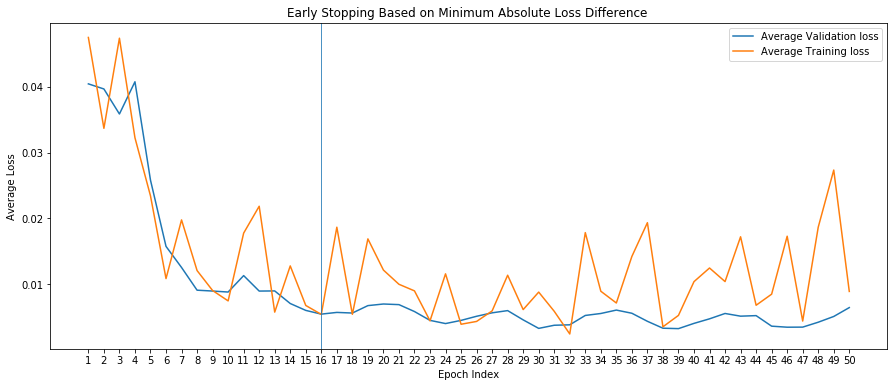

In [13]:
#Computing the stopping epoch
stp_epoch=abs(tr_result_df["Average Loss"]-val_result_df["Average Loss"]).sort_values().head(1).index[0]

epochs_idx=np.array(range(epochs))+1
plt.figure(figsize=(15,6))
plt.plot(epochs_idx,tr_result_df["Average Loss"],label="Average Validation loss")
plt.plot(epochs_idx,val_result_df["Average Loss"],label="Average Training loss")
plt.legend()
plt.xticks(epochs_idx)
plt.xlabel("Epoch Index")
plt.ylabel("Average Loss")
plt.axvline(stp_epoch,linewidth=0.8)
t=plt.title("Early Stopping Based on Minimum Absolute Loss Difference ")


## VI. Results
In this section, we discuss the results of the trained model on the test set. We run the model below, predicting NORMAL or PNEUMONIA for each of the input images in the test set. Relevant metrics are then first computed and presented before being discussed.

In [14]:
#Saving the selected model. Commented out here, but model should be included in submission and can be downloaded at:
#https://qmulprod-my.sharepoint.com/:u:/g/personal/ah19432_qmul_ac_uk/EVryOQTgoCdOi3tPAMspduABgz6XZj_1LTacKJrZQC_qww?e=IsZeWO
# PATH=os.getcwd()
# PATH = os.path.join(PATH, "model_epoch16.pth")
# torch.save(saved_model, PATH)

In [15]:
#Model is loaded from file here
model_name = "model_epoch16.pth"
model = Net()
model.load_state_dict(torch.load(model_name))
model.to(device)
model.eval()

Net(
  (conv1_1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_1): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_1): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (big_pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [16]:
total_ts = 0
correct_ts = 0
TP_ts = 0
FP_ts = 0
FN_ts = 0
loss_ts = 0
model.eval()
sample_images = [[[],[]],[[],[]]] 
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted_ts = torch.max(outputs.data, 1)
        total_ts += labels.size(0)
        correct_ts += (predicted_ts==labels).sum().item()
        actual = labels.item()
        predicted = predicted_ts.item() 
        sample_images[actual][predicted].append(data)
        #Updating the total validation loss     
        loss_ts += (criterion(outputs, labels)) 
        #Computing True positives: true label 1, predicted as 1
        TP_ts += ((predicted_ts+labels)==2).sum()
        #Computing False positives: true label 0, predicted as 1
        FP_ts += ((predicted_ts-labels)==1).sum()
        #Computing False negatives: true label 1, predicted as 0
        FN_ts += ((predicted_ts-labels)==-1).sum()

#Computing TN
TN_ts = total_ts - TP_ts-FP_ts-FN_ts
loss_ts_avg = loss_ts/total_ts
#Computing Accuracy   
acc = 100*correct_ts/total_ts
precision = 100*(float(TP_ts))/(float(TP_ts+FP_ts))
recall = 100*(float(TP_ts))/(float(TP_ts+FN_ts))
f1_score = 2*(float(precision*recall))/(float(precision+recall))
print('Accuracy of the network on %d test images: %.2f %%' %(total_ts, acc))
print('Precision of the network on %d test images: %.2f %%' %(total_ts, precision))
print('Recall of the network on %d test images: %.2f %%' %(total_ts, recall))
print('F1 score of the network on %d test images: %.2f %%' %(total_ts, f1_score))

Accuracy of the network on 624 test images: 85.58 %
Precision of the network on 624 test images: 82.05 %
Recall of the network on 624 test images: 98.46 %
F1 score of the network on 624 test images: 89.51 %


We also compute the so-called Matthews Correlation Coefficient (MCC) given by the following formula [9]. 

$$MCC = \frac{(TP \times FP)-(FP \times FN)}{\sqrt{(TP+FP) \times (TP+FN) \times (TN+FP) \times (TN+FN)}}$$

Where $TP$, $FP$, $TN$, $FN$ are True Positive, False Positive, True Negative, False Negative respectively. This is another metric for evaluating binary classifiers that presents a better picture than accuracy, epecially in cases where there is class imbalance in the test set (such as the present case). While the $F_1$ score has the same objective, the key advantage of the MCC over it is that it takes into account the true negative cases, which are not included in the computation for the $F_1$ score. This MCC value, which ranges from $-1$ to $1$ (a value of $1$ meaning perfect classification) is computed and displayed below. 

In [17]:
def MCC(TP, TN, FP, FN):
    """
    Computes the Matthews Correlation Coefficient [9]. Note that there are times when this will not be computable, most
    notably when the denominator zeroes out if, for example, True Negative and False Positive are both 0. 
    
    @param
    TP: True positives
    TN: True negatives
    FP: False positives
    FN: False negatives 
    
    @return
    Value of the Matthews Correlation Coefficient as described above
    """
    #We include an assert statement here in case the value is not computable
    assert (TP+FP)!=0 and (TP+FN)!=0 and (TN+FP)!=0 and (TN+FN)!=0, "Cannot compute MCC"
    
    numerator = (TP*TN) - (FP*FN)
    denominator = np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    return numerator/denominator

mcc_val = MCC(float(TP_ts.cpu()), float(TN_ts.cpu()), float(FP_ts.cpu()), float(FN_ts.cpu())).item()
print("Matthews Correlation Coefficient of the Network: %.2f" % (mcc_val))

Matthews Correlation Coefficient of the Network: 0.70


#### Result summary for train, validation and test set:

|   |Train|Validation|Test|
|---|---|---|---|
|Average Loss|0.005415|0.005372|0.034264|
|Accuracy|97.16%|97%|85.58%|
|MCC|0.94|0.94|0.699|

Finally, we present a confusion matrix as a breakdown of all the results presented so far and some samples of misclassified cases.

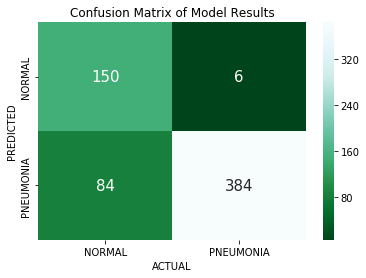

In [18]:
confusion_matrix = np.array([[TN_ts.item(),FN_ts.item() ],[FP_ts.item(), TP_ts.item()]])

#We plot the confusion matrix in a heatmap 
ax = sns.heatmap(confusion_matrix, cmap="BuGn_r", annot=True, annot_kws={"size": 15, "va": "center"}, fmt="d", 
                 xticklabels=["NORMAL","PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
#Some code below for the formatting of the confusion matrix 
ax.set_ylim([0,2])
ax.invert_yaxis()
ax.set_title("Confusion Matrix of Model Results")
ax.set_ylabel("PREDICTED")
ax.set_xlabel("ACTUAL")
for label in ax.get_yticklabels():
    label.set_verticalalignment('center')

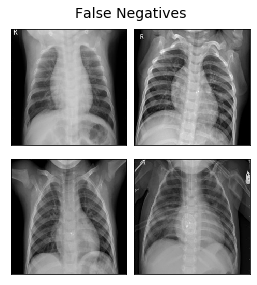

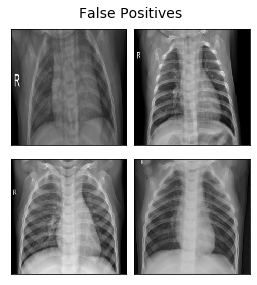

In [19]:
#Actual 1 predicted 0
fn_images = sample_images[1][0]
#Actual 0 predicted 1
fp_images = sample_images[0][1]

#Let's plot 4 False Negatives and 4 False Positives
def plot_image_grid(image_list, rows, cols, title):
    fig = plt.figure()
    fig.suptitle(title, fontsize=14)
    for i in range(0,rows*cols):
        plt.subplot(rows,cols,i+1, xticks=[], yticks=[])
        plt.imshow(image_list[i][0].cpu().permute(1,2,0))
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.set_size_inches(4,4)

plot_image_grid(fn_images, 2, 2, "False Negatives")
plot_image_grid(fp_images, 2, 2, "False Positives")

The model achieved an accuracy of $85.58\%$, an $F_1$ score of $89.51\%$ and a pretty good MCC value of around $0.70$. Since all three of these metrics somewhat agree, we can conclude that the model performed quite well. One thing of note is that most of the misclassifications from the model were false positives (NORMAL cases predicted as PNEUMONIA) and there were very few false negatives. From a medical perspective, this is a good thing as false negatives are much more costly than false positives since patients go home and possibly spread a disease not knowing they are actually sick. 

## VII. Conclusion
In conclusion, one may say that it is indeed possible to classify NORMAL and PNEUMONIA cases using chest X-ray images and a relatively simple neural network that fits in a consumer graphics card (< 6GB of vRAM). The model described here performed quite well with an accuracy of around $85.58\%$ where most of the misclassifications are the less costly false positives. This kind of performance is a somewhat promising result given that there may be times when pneumonia is diagnosed with other tests, such as a blood or sputum test, instead of just a chest X-ray alone [1]. 

Given more time, there are still things that can be extended and improved with this study. Further tuning hyperparameters of both the model and optimisation method might produce better results. Lastly, the data set used for this study included labels for bacterial and viral pneumonia and could thus be formulated as a multi-class classification problem. This would roughly even out class imbalance, but introduce additional complexity in the problem. 

## VIII. References 
[1] NHS. 2019. Pneumonia. https://www.nhs.uk/conditions/pneumonia/.  
[2] Paul Mooney. 2018. Chest X-Ray Images (Pneumonia). https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.  
[3] Andrew Ng. 2017. C4W2L02 Classic Network. https://www.youtube.com/watch?v=dZVkygnKh1M.  
[4] Weidong Xu, Zeyu Zhao, and Tianning Zhao.Tutorial: Dropout as Regularization and Bayesian Approximation. https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/.  
[5]  Sergey Ioffe and Christian Szegedy.2015. Batch normalization: Accelerating deep network training by reducing internal covariate shift. International Conference on Machine Learning (ICML) https://arxiv.org/abs/1502.03167.  
[6] Shibani Santurkar et al. 2019. How Does Batch Normalization Help Optimization? Advances in Neural Information Processing Systems https://arxiv.org/pdf/1805.11604.pdf.  
[7] Leslie Smith. 2017. Cyclical Learning Rates for Training Neural Networks. https://arxiv.org/pdf/1506.01186.pdf.  
[8] Ayoosh Kathuria. 2018. Intro to optimization in deep learning: Momentum, RMSProp and Adam. https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/.  
[9] Davide Chicco, and Giuseppe Jurman. 2020. The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation. https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7.  


## Appendix
Below is some of the code used for preprocessing such as the function used for resizing of images and horizontal flipping.

In [20]:
def flip_images(input_path, output_path):
    """
    Horizontally flips all images in an input path and saves them to the output path
    
    Programmed with some help from: 
    https://techtutorialsx.com/2019/04/21/python-opencv-flipping-an-image/
    
    @param
    input_path: file path to input images
    output_path: file path to location for saving output images 
    """
    for curr_folder in os.listdir(input_path):
        label = curr_folder   
        image_folder_path = os.path.join(input_path, curr_folder)
        output_folder_path = os.path.join(output_path, curr_folder)
        for image_file in tqdm(os.listdir(image_folder_path)):
            file_path = os.path.join(image_folder_path, image_file)
            image_file = "flipped_" + image_file
            output_file_path = os.path.join(output_folder_path, image_file)
            image = cv2.imread(file_path)
            #Flip the image horizontally
            flipped_image = cv2.flip(image, 1)
            cv2.imwrite(output_file_path, flipped_image)
            
def resize_images(input_path, output_path, resize_height=224, resize_width=224): 
    """
    Resizes images in a given input path and saves them to a given output path. 
    
    Reference:
    Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, 
    Neil Yager, Emmanuelle Gouillart, Tony Yu, and the scikit-image contributors. 
    2014. scikit-image: Image processing in Python. https://doi.org/10.7717/peerj.453

    @param
    input_path: file path to input images
    output_path: file path to location for saving output images
    resize_height: height to resize images to 
    resize_width: width to resizes images to 
    """
    for curr_folder in os.listdir(input_path):
        label = curr_folder
        if label=="chest_xray":
            continue
        image_folder_path = os.path.join(input_path, curr_folder)
        output_folder_path = os.path.join(output_path, curr_folder)
        for image_file in tqdm(os.listdir(image_folder_path)):
            file_path = os.path.join(image_folder_path, image_file)
            output_file_path = os.path.join(output_folder_path, image_file)
            image = cv2.imread(file_path)
            image = skimage.transform.resize(image, (resize_height, resize_width))
            #Transform from normalised version back to the 255 range and then cast to integers
            cv2.imwrite(output_file_path, np.uint8(image*255))